In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler

from tqdm import tqdm, tqdm_notebook

In [2]:
data_df = pd.read_csv('data.tsv', sep='\t', names=['datetime', 'id', 'type', 'route_id', 'lat', 'lon'])
target_stops = pd.read_csv('debug.tsv', sep='\t', names=['transport_type', 'route_id', 'lat', 'lon'])

print(data_df.shape)

(1064095, 6)


In [3]:
data_df['datetime'] = pd.to_datetime(data_df['datetime'])


In [4]:
data_df.head()

,datetime,id,type,route_id,lat,lon
0,2015-05-12 14:24:33,3982,tramway,1,50.700576,51.212909
1,2015-05-12 14:25:13,3982,tramway,1,50.702068,51.212772
2,2015-05-12 14:25:53,3982,tramway,1,50.702930,51.212703
3,2015-05-12 14:26:33,3982,tramway,1,50.705974,51.212421
4,2015-05-12 14:27:13,3982,tramway,1,50.706775,51.212428


In [5]:
data_df.count()

datetime    1064095
id          1064095
type        1064095
route_id    1064095
lat         1064095
lon         1064095
dtype: int64

In [6]:
data_df.dtypes

datetime    datetime64[ns]
id                   int64
type                object
route_id             int64
lat                float64
lon                float64
dtype: object

In [7]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1064095.0,4291.581742,2982.796960,759.000000,1501.000000,3475.000000,7136.000000,10319.000000
route_id,1064095.0,63.941277,48.076470,1.000000,29.000000,53.000000,89.000000,224.000000
lat,1064095.0,50.606622,0.084658,50.296417,50.544712,50.611568,50.676059,51.046154
lon,1064095.0,51.106284,0.143798,50.145202,51.053720,51.128475,51.189899,52.058666


отобразим все координаты на плоскость

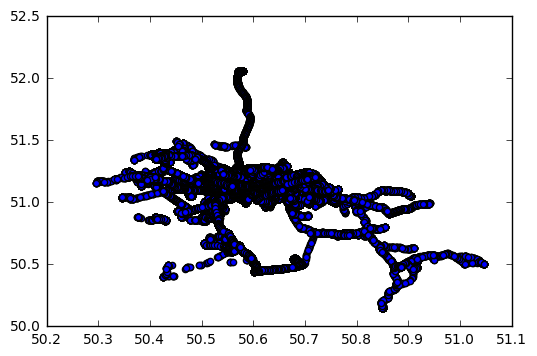

In [8]:
plt.scatter(data_df['lat'],data_df['lon'])

Определим есть ли пересечение в маршрутах для различного типа транспорта, вообще логично если есть

In [8]:
data_df['type'].unique()

array(['tramway', 'bus', 'trolleybus'], dtype=object)

In [10]:
print('tramway : ',np.unique(data_df[data_df['type']=='tramway']['route_id']))
print('bus : ',np.unique(data_df[data_df['type']=='bus']['route_id']))
print('trolleybus : ',np.unique(data_df[data_df['type']=='trolleybus']['route_id']))

tramway :  [  1   2   3   5  11  14  15  16  17  18  19  21  22  23  24  25  27  28
  29  30  31  32  33  39  41  45  48  49  51  54  70  71  72  75  76  77
  78  79 103]
bus :  [  3   4   5   6   7   8   9  10  11  12  13  14  15  18  22  23  24  25
  26  27  28  30  31  32  34  35  36  37  38  39  40  42  43  45  46  47
  48  50  52  53  55  56  57  58  59  60  61  62  63  64  65  66  67  68
  69  71  72  73  74  76  77  79  80  81  82  83  84  85  86  87  89  90
  91  92  93  94  95  97  98  99 100 102 103 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 152 153 155 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 224]
trolleybus : 

In [4]:
tram_routes = np.unique(data_df[data_df['type']=='tramway']['route_id'])
bus_routes = np.unique(data_df[data_df['type']=='bus']['route_id'])
trol_routes = np.unique(data_df[data_df['type']=='trolleybus']['route_id'])

print('count of routes tramway = %d| count of routes bus = %d| count of routes trolleybus = %d'%(tram_routes.shape[0],bus_routes.shape[0],trol_routes.shape[0]))

count of routes tramway = 39| count of routes bus = 199| count of routes trolleybus = 43


In [5]:
data_bus = data_df[(data_df['type']=='bus')&(data_df['route_id']==bus_routes[1])]

In [6]:
data_bus.shape

(19221, 6)

In [46]:
bus_routes[1]

4

In [6]:
unq_bus = data_bus['id'].unique()

наверное популярный маршрут много автобусов ходят

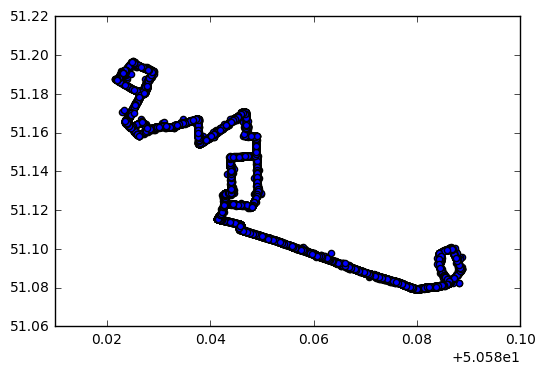

In [15]:
plt.scatter(data_bus['lat'],data_bus['lon'])

In [7]:
bus_id = data_bus[data_bus['id']==unq_bus[1]]

In [8]:
bus_id.shape
bus_id.head()

,datetime,id,type,route_id,lat,lon
68701,2015-05-12 02:21:24,1036,bus,4,50.666511,51.099836
68702,2015-05-12 02:22:44,1036,bus,4,50.664741,51.095104
68703,2015-05-12 02:23:44,1036,bus,4,50.665126,51.086566
68704,2015-05-12 02:24:44,1036,bus,4,50.666279,51.082240
68705,2015-05-12 02:25:44,1036,bus,4,50.665363,51.081512


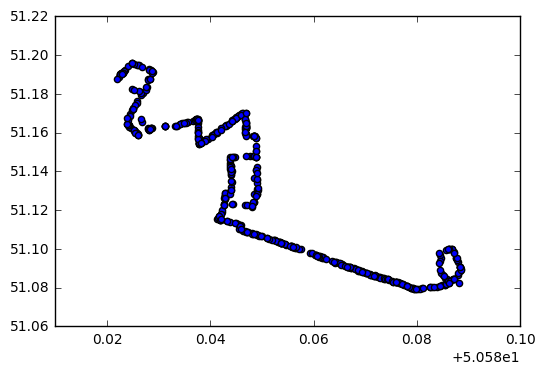

In [9]:
plt.scatter(bus_id['lat'],bus_id['lon'])

In [10]:
from ipywidgets import widgets, interact

In [11]:
unq_tm = np.sort(bus_id['datetime'].unique())
n_tm = unq_tm.shape[0]

In [12]:
def fnc(x):
    bs_tm = bus_id[bus_id['datetime']<=unq_tm[x]][:]
    plt.scatter(bs_tm['lat'],bs_tm['lon'])
    plt.show()
    return unq_tm[x]

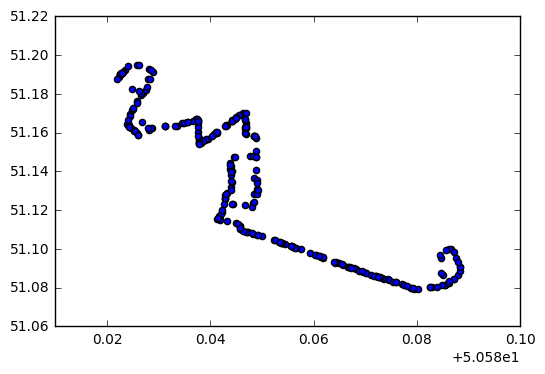

numpy.datetime64('2015-05-12T11:50:07.000000000')

<function __main__.fnc>

In [13]:
interact(fnc,x=(0,n_tm-1))

отображение на карте заданного типа транспорта с уникальным ид маршрута и ид транспортного средства в текущей момент времени
уникальные маршруты хранятся вследующих массивах
* tram_routes
* bus_routes
* trol_routes

далее необходимо взять ид транспортного средства

что бы работал вывод скоростей и задержек надо закачать файл с дополнительной информацией ниже есть загрузка
или вычислить самому эти параметры как в блоке (вычисления доп. параметров ниже)

In [ ]:
data_cp = pd.read_csv('dataNew.tsv',sep='\t')
data_cp['datetime'] = pd.to_datetime(data_cp['datetime'])

In [14]:
uniq_transport = np.unique(data_df[(data_df['type']=='bus')&(data_df['route_id']==bus_routes[68])]['id'])
transp_id = data_df[(data_df['type']=='bus')&(data_df['route_id']==bus_routes[68])&(data_df['id']==uniq_transport[2])]
transp_id.shape

(1105, 6)

In [35]:
#для скорости
transpExt_id = data_cp[(data_df['type']=='bus')&(data_df['route_id']==bus_routes[68])&(data_df['id']==uniq_transport[2])]

(1105, 10)

In [15]:
target_stops['transport_type'].unique()

array(['bus', 'tramway', 'trolleybus'], dtype=object)

In [16]:
print(target_stops[target_stops['transport_type']=='bus']['route_id'].unique())
print(target_stops[target_stops['transport_type']=='tramway']['route_id'].unique())
print(target_stops[target_stops['transport_type']=='trolleybus']['route_id'].unique())

[86]
[11]
[71]


In [17]:
target_bus_stops= target_stops[target_stops['transport_type']=='bus']
target_bus_stops.shape

(47, 4)

In [19]:
import math
thresh_size = 45.0

def calc_dist(point1, point2):
    rad = 6372795
    #косинусы и синусы широт и разницы долгот
    cl1 = math.cos(point1[0]*math.pi/180.)
    cl2 = math.cos(point2[0]*math.pi/180.)
    sl1 = math.sin(point1[0]*math.pi/180.)
    sl2 = math.sin(point2[0]*math.pi/180.)
    delta = point2[1]*math.pi/180. - point1[1]*math.pi/180.
    cdelta = math.cos(delta)
    sdelta = math.sin(delta)
    #вычисления длины большого круга
    y = math.sqrt(math.pow(cl2*sdelta,2)+math.pow(cl1*sl2-sl1*cl2*cdelta,2))
    x = sl1*sl2+cl1*cl2*cdelta
    ad = math.atan2(y,x)
    dist = ad*rad
    #вычисление начального азимута
    x = (cl1*sl2) - (sl1*cl2*cdelta)
    y = sdelta*cl2
    if x==0:
        x = x + 0.000001
    z = math.degrees(math.atan(-y/x))

    if (x < 0):
        z = z+180.

    z2 = (z+180.) % 360. - 180.
    z2 = - math.radians(z2)
    anglerad2 = z2 - ((2*math.pi)*math.floor((z2/(2*math.pi))) )
    angledeg = (anglerad2*180.)/math.pi
    
    return dist, int(angledeg/thresh_size)

In [55]:
unq_time = np.sort(transp_id['datetime'].unique())
len_time = unq_time.shape[0]

def fnc(x):
    bs_tm = transp_id[transp_id['datetime']<unq_time[x]][:]
    lt, ln = transp_id[transp_id['datetime']==unq_time[x]][['lat','lon']].values[0]
    rws=transpExt_id[transpExt_id['datetime']==unq_time[x]][['datetime','delay','dist','direction','velocity']]
    print(rws)
    plt.figure(figsize=(10,7))
    plt.scatter(bs_tm['lat'],bs_tm['lon'],marker='o',color='blue')
    plt.scatter(lt,ln,marker='o',color='red')
    plt.scatter(target_bus_stops['lat'], target_bus_stops['lon'], marker='x', color='green', s=50)
    plt.show()    
    return unq_time[x]

                  datetime  delay       dist  direction  velocity
659412 2015-05-12 13:37:31   20.0  21.585312        4.0  1.079266


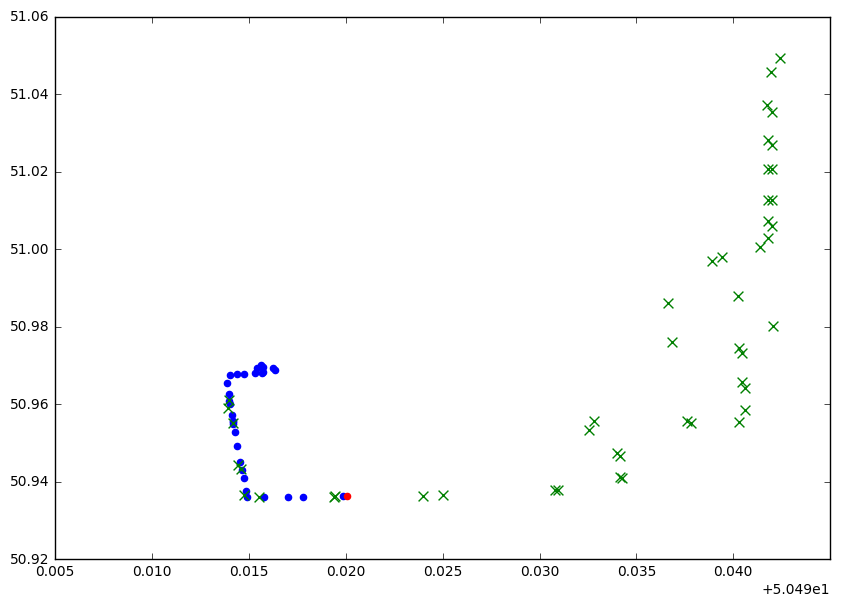

numpy.datetime64('2015-05-12T13:37:31.000000000')

In [56]:
interact(fnc,x=(0,len_time-1))

In [33]:
data_df.head()

,datetime,id,type,route_id,lat,lon
0,2015-05-12 14:24:33,3982,tramway,1,50.700576,51.212909
1,2015-05-12 14:25:13,3982,tramway,1,50.702068,51.212772
2,2015-05-12 14:25:53,3982,tramway,1,50.702930,51.212703
3,2015-05-12 14:26:33,3982,tramway,1,50.705974,51.212421
4,2015-05-12 14:27:13,3982,tramway,1,50.706775,51.212428


In [36]:
#вычисление дополнительных параметров

data_cp = data_df[:]
data_cp['delay']=0.0 
data_cp['dist']=0.0 
data_cp['direction']=0.0 
data_cp['velocity']=0.0 

for transportType in tqdm_notebook(data_cp['type'].unique(), desc='1st loop transport type'):
    unq_routs = np.unique(data_cp[data_cp['type']==transportType]['route_id'])
    for route in tqdm_notebook(unq_routs, desc='2nd loop routes'):
        unq_id = np.unique(data_cp[(data_cp['type']==transportType)&(data_cp['route_id']==route)]['id'])
        for trnsp in tqdm_notebook(unq_id, desc='3rd loop id transport'):
            data_way = data_cp[(data_cp['type']==transportType)&(data_cp['route_id']==route)&(data_cp['id']==trnsp)]
            
            dtws = data_way[['datetime','lat','lon']].values
            tms = dtws[:,0]
            crds = dtws[:,1:]
            crdt = np.append([crds[0]],crds[:-1])
            crdt = crdt.reshape(crds.shape)
            tpmn = np.append([tms[0]],tms[:-1])
            dltm = tms - tpmn
            
            tmdl = np.array([])
            dst = np.array([])
            for ind in np.arange(tms.shape[0]):
                vlf = np.timedelta64(dltm[ind],'s').astype(float)
                tmdl = np.append(tmdl,[vlf])
                vl = calc_dist(crds[ind],crdt[ind])
                dst = np.append(dst,[vl])

            dst = dst.reshape(crds.shape)

            data_way['delay'] = tmdl
            data_way['dist'] = dst[:,0]
            data_way['direction'] = dst[:,1]
            data_way['velocity'] = dst[:,0]/(tmdl+0.0000000001)
            
            data_cp[(data_cp['type']==transportType)&(data_cp['route_id']==route)&(data_cp['id']==trnsp)] = data_way

/home/roman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/roman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/roman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [38]:
data_cp.head()

,datetime,id,type,route_id,lat,lon,delay,dist,direction,velocity
0,2015-05-12 14:24:33,3982,tramway,1,50.700576,51.212909,0.0,0.000000,0.0,0.000000
1,2015-05-12 14:25:13,3982,tramway,1,50.702068,51.212772,40.0,166.229980,3.0,4.155749
2,2015-05-12 14:25:53,3982,tramway,1,50.702930,51.212703,40.0,96.000165,3.0,2.400004
3,2015-05-12 14:26:33,3982,tramway,1,50.705974,51.212421,40.0,339.154965,3.0,8.478874
4,2015-05-12 14:27:13,3982,tramway,1,50.706775,51.212428,40.0,89.093595,4.0,2.227340


In [41]:
data_cp.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1064095.0,4291.581742,2982.796960,759.000000,1501.000000,3475.000000,7136.000000,10319.000000
route_id,1064095.0,63.941277,48.076470,1.000000,29.000000,53.000000,89.000000,224.000000
lat,1064095.0,50.606622,0.084658,50.296417,50.544712,50.611568,50.676059,51.046154
lon,1064095.0,51.106284,0.143798,50.145202,51.053720,51.128475,51.189899,52.058666
delay,1064095.0,93.369071,466.724373,-68263.000000,20.000000,40.000000,81.000000,66702.000000
dist,1064095.0,332.333915,584.318021,0.000000,77.484394,189.774956,411.852899,55570.443203
direction,1064095.0,3.571571,2.282586,0.000000,2.000000,3.000000,6.000000,7.000000
velocity,1064095.0,5.280547,4.180088,-0.052811,2.234260,4.459174,7.132662,83.870919


In [48]:
data_cp.to_csv('/home/roman/work/data/stops/dataNew.tsv', sep='\t',index=False)

In [54]:
df_stopsCount = pd.read_csv( '/home/roman/work/data/stops/route_to_stops_count.tsv', sep = '\t', names = ['type', 'route_id', 'count'])


In [56]:
print(df_stopsCount.shape)
df_stopsCount.head()

(281, 3)


,type,route_id,count
0,bus,86,47
1,bus,55,60
2,bus,198,49
3,bus,98,36
4,bus,107,41


Для классификации пока нехватает размеченной выборки надо разметить для 3-х маршрутов тогда можно обучать классификаторы, пока можно попробовать только кластеризацию

In [57]:
from sklearn.cluster import KMeans

попробуем для тренировочного набора посмотреть что получится из этого

In [66]:
df_stopsCount.values[0]

array(['bus', 86, 47], dtype=object)

In [131]:
tr_type, route, cntStops = df_stopsCount.values[0]

In [125]:
crds = data_cp[(data_cp['type'] == tr_type)][['lat', 'lon', 'velocity']]

In [126]:
kmeans = KMeans(n_clusters = cntStops, n_init=1).fit(crds)
pred_stpos = kmeans.cluster_centers_


In [138]:
pred_stpos[:,0:2].shape

(47, 2)

посмотрим что получилось

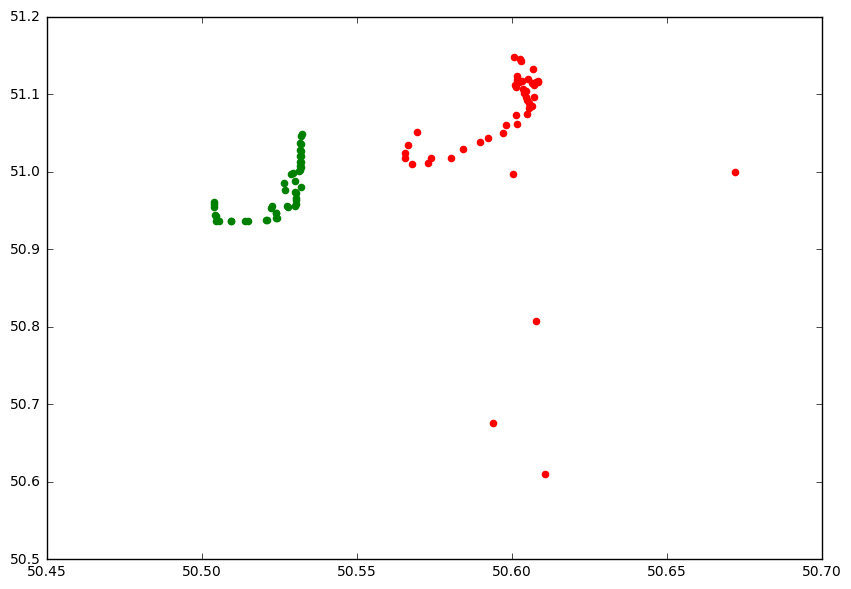

In [129]:
plt.figure(figsize=(10,7))
plt.scatter(pred_stpos[:,0],pred_stpos[:,1],marker='o',color='red')
plt.scatter(target_bus_stops['lat'],target_bus_stops['lon'],marker='o',color='green')
plt.show()
    

при кластеризации со скоростью центры кластеров как-то всё-таки напоминают маршрут(что-то похожее есть)

In [114]:
from mpl_toolkits.mplot3d import Axes3D

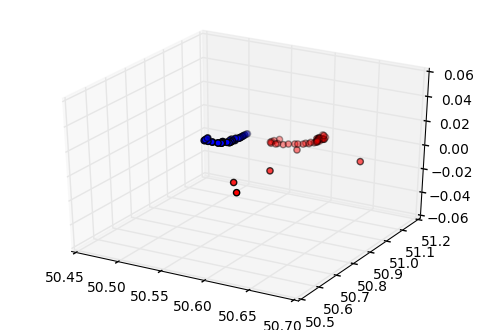

In [130]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pred_stpos[:,0], pred_stpos[:,1], 0, c='r')
ax.scatter(target_bus_stops['lat'],target_bus_stops['lon'], 0, c='b')
plt.show()

что-то странно..  почему центры кластеров за пределами множества точек...

In [158]:
listStops = np.array([])
for row in tqdm_notebook(df_stopsCount.values):
    tr_type, route, cntStops = row
    #координаты для кластеризации
    crds = data_cp[(data_cp['type'] == tr_type)][['lat', 'lon', 'velocity']]
    kmeans = KMeans(n_clusters = cntStops, n_init=1).fit(crds)
    pred_stpos = kmeans.cluster_centers_
    listStops = np.append(listStops,pred_stpos[:,0:2][:])
    listStops = listStops.reshape((listStops.shape[0]/2,2))

/home/roman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [178]:
listStops.shape

(12021, 2)

In [173]:
pd.DataFrame(listStops).tail()

,0,1
12016,50.565421,51.029541
12017,50.610292,50.611217
12018,50.595090,50.661526
12019,50.602820,51.142986
12020,50.600961,51.064807


In [184]:
listStops.shape

(12021, 2)

In [181]:
listStopsVel = listStops[:]

In [180]:
np.savetxt('/home/roman/work/data/stops/answ3.txt',listStops,fmt='%.9s')

In [171]:
pd.DataFrame(listStops).to_csv('/home/roman/work/data/stops/answ1.txt',sep=' ',header=False, index=False)

In [201]:
listStops = np.array([])
for row in tqdm_notebook(df_stopsCount.values):
    tr_type, route, cntStops = row
    #координаты для кластеризации
    if not((tr_type=='bus' and route==86)or(tr_type=='tramway' and route==11)or(tr_type=='trolleybus' and route==71)):
        crds = data_cp[(data_cp['type'] == tr_type)][['lat', 'lon']]
        kmeans = KMeans(n_clusters = cntStops, n_init=1).fit(crds)
        pred_stpos = kmeans.cluster_centers_
        listStops = np.append(listStops,pred_stpos[:])
        listStops = listStops.reshape((listStops.shape[0]/2,2))

/home/roman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [183]:
np.savetxt('/home/roman/work/data/stops/answ3_1.txt',listStops,fmt='%.9s')

In [200]:
listStopsAll = listStops[:]

In [211]:
npvls = target_stops[['lat','lon']].values[:]

In [214]:
listStops = np.append(listStops,npvls[:])
listStops = listStops.reshape((listStops.shape[0]/2,2))

/home/roman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


In [216]:
np.savetxt('/home/roman/work/data/stops/answ3_2.txt',listStops,fmt='%.9s')